<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Partie_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python -m spacy download fr_core_news_md
import nltk
nltk.download('punkt')

     |████████████████████████████████| 88.6MB 84.9MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338488 sha256=b9938001c4e1b02554b5b391c98dba097ad394bb9f6c77445c310af075b7a288
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3ybft67/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import pandas as pd
from funct import *
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.corpus import stopwords
from collections import Counter
import spacy
from spacy.tokenizer import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
import funct
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Importations des données

Nous importons un dataframe contenant uniquement 500 discours politiques ou déclaration. Les autres types d'élocutions n'ont pas été sélectionnées. Nous avons gardé du genre dans notre corpus de documents

In [0]:
df = pd.read_csv('minimal_df.csv')

Clean encodage

In [0]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [4]:
df.sexe.map(str).value_counts()

1    361
2    139
Name: sexe, dtype: int64

# Premières visualisation simples

On essaie de voir les différentes différences entre les hommes et les femmes

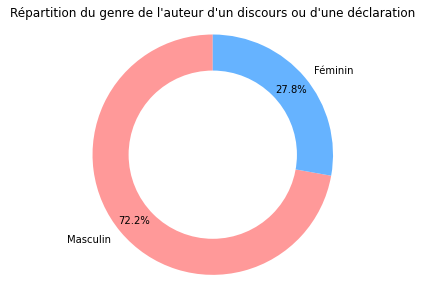

In [6]:
labels = ['Masculin','Féminin']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition du genre de l'auteur d'un discours ou d'une déclaration")
plt.show()

On observe que le nombre de prise de paroles des femmes commence à augmenter légèrement

Text(0.5, 1.0, "Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

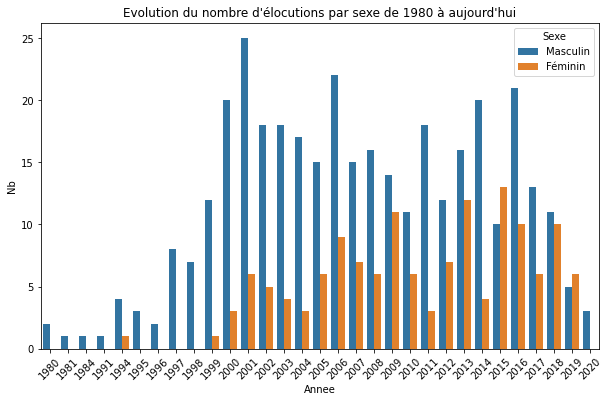

In [8]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Masculin'
        else:
            sexe='Féminin'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

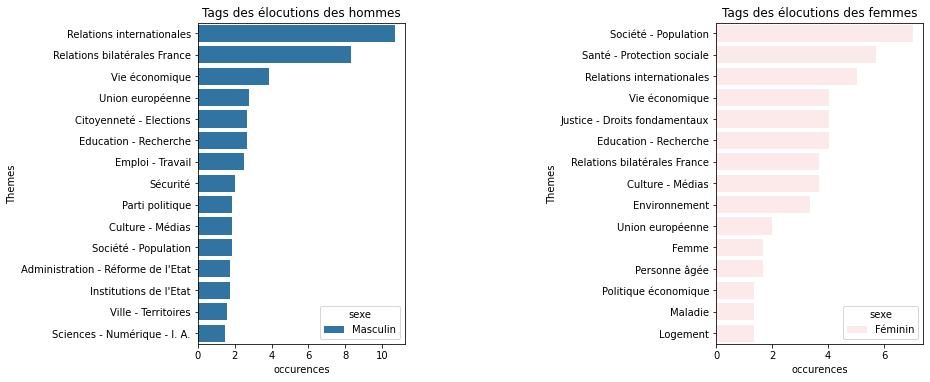

In [9]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Féminin'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Masculin'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Masculin')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           hue='sexe')
plt.title("Tags des élocutions des hommes")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Féminin')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           hue='sexe',
           color = 'red')
plt.title("Tags des élocutions des femmes")
plt.subplots_adjust(wspace = 1.5)

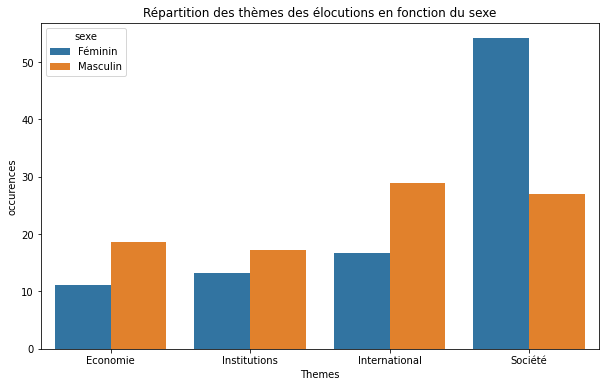

In [10]:
# THEMES
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Féminin'
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Masculin'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

Désormais nous allons nous concentrer sur le texte uniquement. Pour le faire, nous créeons dans un premier temps un ensemble de fonctions permettant d'étudier le texte.

Nous tokenizons notre text pour pouvoir le travailler et sortir d'autres variables par la suite. 

Nous allons tester plusieurs tokenizer pour voir lequel marche le mieux.

Commençons par le tokenizer français de Spacy.

Puis par celui de nltk

Et enfin Tokenizer basé sur le regex, on remarqu'il ne fonctionne pas bien car tokenize "c'est" en deux "c'" et "est".

In [0]:
tokenizer = Tokenizer(nlp.vocab)

In [13]:
print(len([w for w in tokenizer(df.Texte[0])]))
print(len(word_tokenize(df.Texte[0], language='french')))
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
len(toknizer.tokenize(df.Texte[0]))

4259
4653


5177

On remarque une différence, le tokenizer de nltk tokenize la ponctuation tandis que celui de spacy ne le fait pas visiblement. On va donc utiliser plutôt le tokenizer de nltk.

Pour les stopwords, il semblerait que la liste de spacy soit bien plus complète

In [16]:
len(list(fr_stop)),len(stopwords.words('french'))

(600, 157)

In [0]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

Il y a un problème avec le détecteur  français de phrase de nltk... 

Une fonction sent_detector_mano permet de mieux compter ce nombre de phrases

In [7]:
print(len(sent_detector.tokenize(df.Texte[1])))
#sent_detector.tokenize(df.Texte[1])
print(len(df.Texte[1].split('.')))
#df.Texte[1].split('.'))
print(len(sent_detector_mano(df.Texte[1])))
#sent_detector_mano(df.Texte[1])

46
74
77


J'ai ajouté un cleaner pour les Noms/Prénoms des politiques basés sur les noms/prénoms des personnalités politiques présentes dans la base. 

J'ajoute également un cleaner pour Mr, Mme , M , Madame et Monsieur, Mesdames, Messieurs.

Voir si président et ministre sont à ajouter.

In [0]:
lst_nom = [nom for nom in set(df.Nom+ ' ' +df.Prenom) if nom not in 'ministère'] + [nom for nom in set(df.Prenom+ ' ' +df.Nom) if nom not in 'ministère']+ [nom for nom in set(df.Prenom) if nom != 'ministère'] + [nom for nom in set(df.Nom) if nom != 'ministère']
cleanFast = lst_nom + ['Mr','M','Mme','Madame','Monsieur','monsieur','madame','mme','mr','mesdames','messieurs']

In [0]:
df['CleanToken'] = df.Texte.apply(cleanToken)
df.CleanToken = df.apply(lambda row : FastCleaner(row.CleanToken,cleanFast),axis=1)

In [9]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [0]:
def add_features(df):
  """
    Sert pour la parallélisation
    Input : DataFrame
    Output : DataFrame avec les nouvelles colonnes crée
  """

In [0]:
df['NbCleanToken'] = df.Texte.apply(lambda x : len(cleanToken(x)))
df['NbSyllables'] = df.Texte.apply(NbSyllables)
df['NbMot'] = df.Texte.apply(extraire_nb_mot)
df['Phrases'] = df.Texte.apply(sent_detector_mano)
df['NbPhrases'] = df.Texte.apply(lambda x:len(sent_detector_mano(x)))
df['CleanToken'] = df.Texte.apply(cleanToken)
df.CleanToken = df.apply(lambda row : FastCleaner(row.CleanToken,cleanFast),axis=1)
df['NbCleanToken']=df.CleanToken.apply(len)
df['NbPonct'] = df.Texte.apply(count_punct)
df['NbSw'] = df.Token.apply(count_stopwords)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))
df['RateCleanRaw'] = df.NbCleanToken/df.NbToken
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)
df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)
#C'est extrêmement long ... j'imagine même pas avec 20 000 discours ...
#J'ai arrangé quelques trucs, ca devrait aller plus vite quand même  

In [0]:
df[['NbNom_prec']]=df[['NbNom']].div(df.NbMot,axis=0)

df[['NbDet_prec']]=df[['NbDet']].div(df.NbMot,axis=0)

df[['NbAdj_prec']]=df[['NbAdj']].div(df.NbMot,axis=0)

df[['NbPron_prec','NbVerb_perc','NbAUX_perc']]=df[['NbPron','NbVerb','NbAUX']].div(df.NbMot,axis=0)

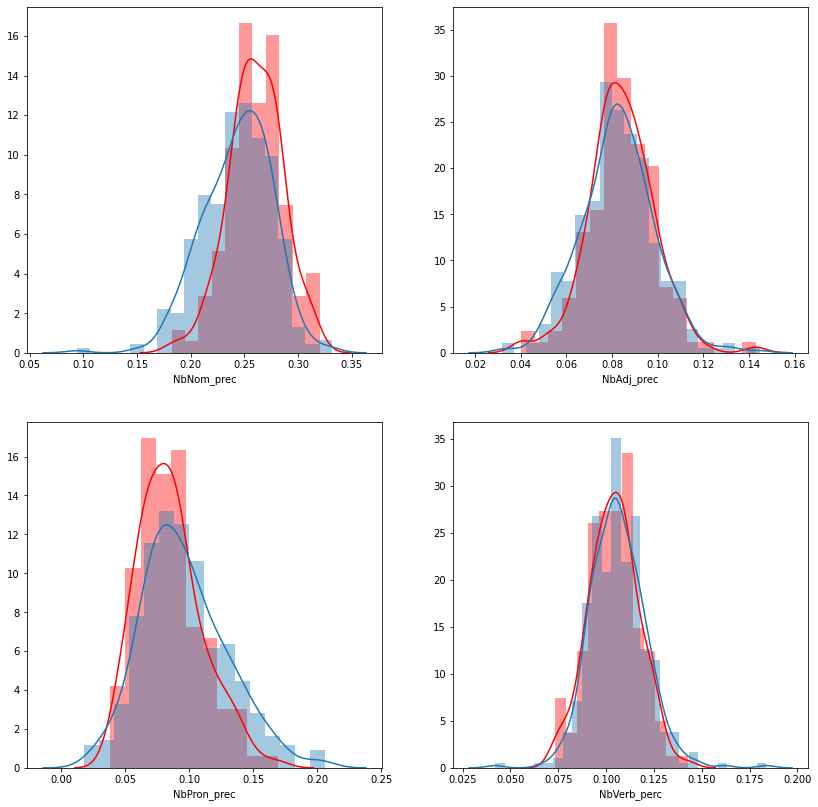

In [49]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbNom_prec'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbNom_prec'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbAdj_prec'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbAdj_prec'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['NbPron_prec'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbPron_prec'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['NbVerb_perc'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbVerb_perc'])
plt.show()

Au dela du nombre ce qui est interessant d'observer c'est quel type de pronom, nom, verbes les hommes et les femmes utilisent. 

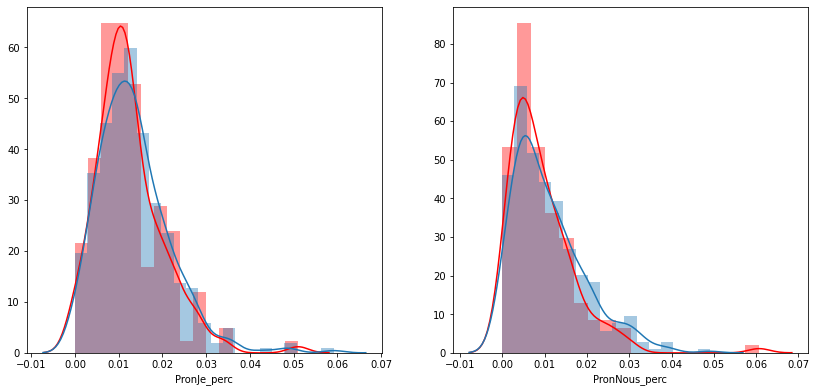

In [32]:
lst = lst=[ 'NbSyllables','NbPhrases','FRE','NbMot','NbToken','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 
       'UniqueWordTx', 'RateCleanRaw','NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb',
        'NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','NbArt', 'F_mesure'
        ]
lst = lst + ['NbNom_prec','NbDet_prec','NbAdj_prec',
    'NbPron_prec','NbVerb_perc','NbAUX_perc']
df[['PronJe_perc','PronNous_perc']]=df[['PronJe','PronNous']].div(df.NbMot,axis=0)
lst = lst + ['PronJe_perc','PronNous_perc']
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['PronJe_perc'],color = 'red')
sns.distplot(df[df.sexe == 1]['PronJe_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['PronNous_perc'] ,color = 'red')
sns.distplot(df[df.sexe == 1]['PronNous_perc'])
plt.show()
# On voit mieux faut agrandir un peu les graphs au dessus met en que deux par colonnes 

De plus grosses différences sur le j en terme de distr mais une queue de distribution plus importante pour les nous en bas ( à voir finalement si je divise par le nombre de pronom pas vraiment. 

Trop hate d evoir les résultats sur le corpus entier !! 

Les distplot ca a pas trop de sens la comme c'est super biaisé a gauche ca suit une expo ou une gamma, on peut l'approximer par un expo si c'est faisble

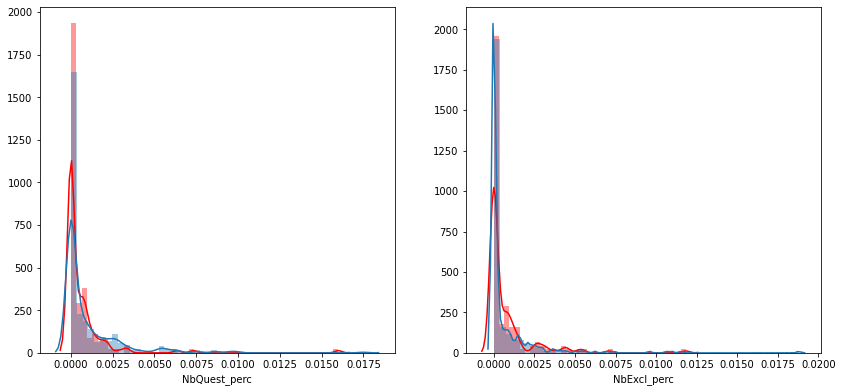

In [33]:
df[['NbQuest_perc','NbExcl_perc']]=df[['NbQuest','NbExcl']].div(df.NbToken,axis=0)
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbQuest_perc'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbQuest_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbExcl_perc'],color = 'red')
sns.distplot(df[df.sexe == 1]['NbExcl_perc'])
plt.show()

In [2]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

#Je veux pas faire la féministe mais ces dessins ? hahaha 

NameError: ignored